In [2]:
import pandas as pd
movies = pd.read_csv("Data/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [3]:
ratings = pd.read_csv("Data/ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib

movies_expanded = movies.copy()
movies_expanded['genres'] = movies_expanded['genres'].str.split('|')
movies_expanded = movies_expanded.explode('genres')

data = ratings.merge(movies_expanded, on='movieId')

genres = sorted(data['genres'].unique())
genre_to_index = {genre: i for i, genre in enumerate(genres)}
n_arms = len(genres)

user_ids = data['userId'].unique()
n_users = 100 

### 밴디트 알고리즘 

In [9]:
from collections import defaultdict
import random

def run_bandit_simulation(epsilon, alpha=None, dynamic=False, steps=500):
    rewards_total = np.zeros(steps)
    optimal_action_total = np.zeros(steps)

    for user_id in random.sample(list(user_ids), n_users):
        user_data = data[data['userId'] == user_id]

        genre_success_rate = user_data.groupby('genres')['rating'].apply(lambda x: (x >= 4.0).mean())
        true_probs = np.array([genre_success_rate.get(g, 0) for g in genres])
        best_arm = np.argmax(true_probs)

        Q = np.zeros(n_arms)
        N = np.zeros(n_arms)

        for t in range(steps):
            if np.random.rand() < epsilon:
                action = np.random.randint(n_arms)
            else:
                action = np.argmax(Q)

            reward = 1 if np.random.rand() < true_probs[action] else 0

            if alpha is None:
                N[action] += 1
                Q[action] += (reward - Q[action]) / N[action]
            else:
                Q[action] += alpha * (reward - Q[action])

            rewards_total[t] += reward
            if action == best_arm:
                optimal_action_total[t] += 1

            if dynamic and t % 100 == 0 and t > 0:
                true_probs = np.clip(true_probs + np.random.normal(0, 0.05, n_arms), 0, 1)

    rewards_avg = rewards_total / n_users
    optimal_action_avg = optimal_action_total / n_users
    return rewards_avg, optimal_action_avg

In [34]:
epsilons = [0.01, 0.1, 0.3]
results = {}

for eps in epsilons:
    rewards, optimal = run_bandit_simulation(epsilon=eps)
    results[eps] = {'rewards': rewards, 'optimal': optimal}

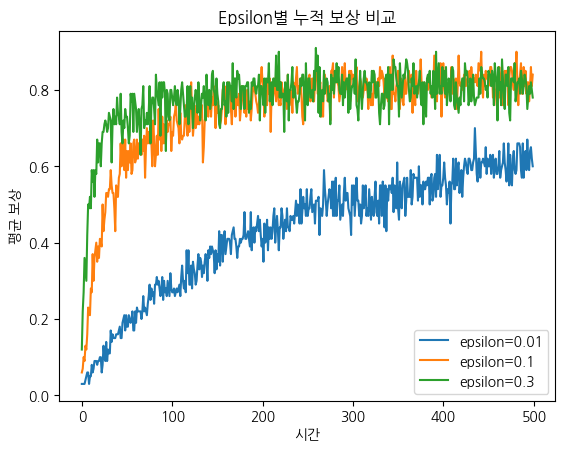

In [35]:
for eps in epsilons:
    plt.plot(results[eps]['rewards'], label=f'epsilon={eps}')
plt.title("Epsilon별 누적 보상 비교")
plt.xlabel("시간")
plt.ylabel("평균 보상")
plt.legend()
plt.show()

In [38]:
from tqdm import tqdm

runs = 200
steps = 500
epsilons = [0.01, 0.1, 0.3]

epsilon_multi_avg = {}

for eps in epsilons:
    multi_run_rates = np.zeros((runs, steps))
    for run in tqdm(range(runs), desc=f"Epsilon={eps}"):
        rewards, _ = run_bandit_simulation(epsilon=eps, steps=steps)
        multi_run_rates[run] = rewards
    avg_multi_run = multi_run_rates.mean(axis=0)
    epsilon_multi_avg[eps] = avg_multi_run

Epsilon=0.3: 100%|███████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.64it/s]


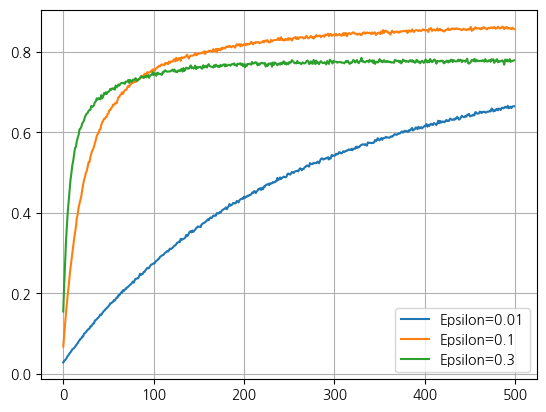

In [40]:
for eps in epsilons:
    plt.plot(epsilon_multi_avg[eps], label=f"Epsilon={eps}")
plt.legend()
plt.grid()
plt.show()

In [50]:
epsilon_multi_avg[0.01], epsilon_multi_avg[0.1], epsilon_multi_avg[0.3]

(array([0.0281 , 0.0319 , 0.0343 , 0.03645, 0.04055, 0.0446 , 0.04715,
        0.051  , 0.0533 , 0.0566 , 0.06065, 0.06215, 0.0639 , 0.0669 ,
        0.0703 , 0.0735 , 0.0761 , 0.08035, 0.0833 , 0.08655, 0.0879 ,
        0.09235, 0.09285, 0.09945, 0.101  , 0.10335, 0.1064 , 0.10885,
        0.11135, 0.11205, 0.1177 , 0.11785, 0.12165, 0.1245 , 0.125  ,
        0.1325 , 0.13335, 0.13565, 0.138  , 0.13975, 0.14305, 0.14715,
        0.14605, 0.14995, 0.1529 , 0.15625, 0.15765, 0.16135, 0.16245,
        0.16565, 0.16755, 0.1706 , 0.17495, 0.1751 , 0.1773 , 0.1786 ,
        0.18285, 0.18195, 0.18555, 0.1892 , 0.18915, 0.195  , 0.1947 ,
        0.1984 , 0.202  , 0.20135, 0.20725, 0.20545, 0.2095 , 0.2099 ,
        0.214  , 0.2143 , 0.21675, 0.219  , 0.2208 , 0.22305, 0.2258 ,
        0.2291 , 0.2264 , 0.23185, 0.23585, 0.23615, 0.23705, 0.23735,
        0.2422 , 0.2486 , 0.24545, 0.24715, 0.24825, 0.25305, 0.25315,
        0.25735, 0.25995, 0.26285, 0.262  , 0.2631 , 0.2674 , 0.2704 ,
      

In [69]:
# 평균 Q-value vs 학습률(alpha) Q-value 비교 
avg_rewards_static, avg_optimal_static = run_bandit_simulation(epsilon=0.1, alpha=None, dynamic=False)
alpha_rewards_dynamic, alpha_optimal_dynamic = run_bandit_simulation(epsilon=0.1, alpha=0.3, dynamic=True)

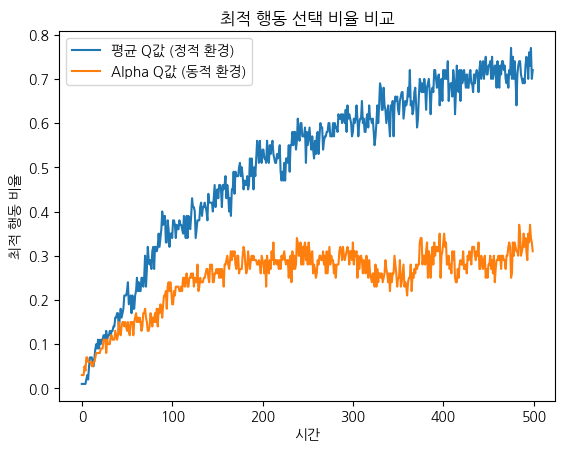

In [71]:
plt.plot(avg_optimal_static, label="평균 Q값 (정적 환경)")
plt.plot(alpha_optimal_dynamic, label="Alpha Q값 (동적 환경)")
plt.title("최적 행동 선택 비율 비교")
plt.xlabel("시간")
plt.ylabel("최적 행동 비율")
plt.legend()
plt.show()

Alpha 방식(학습률 기반 업데이트)이 변화에 더 잘 적응하지만,  그래프 상에서는 최적 행동 선택 비율이 평균 Q 방식보다 낮게 나타난다   
-  best arm이 자주 바뀌는 환경에서는 그 정답률은 낮게 나타날 수 있기 때문
      
학습률 alpha는 최근 보상에 얼마만큼 가중치를 둘지를 결정. 클수록 환경 변화에 빠르게 적응하지만 불안정성 증가함   